In [58]:
import pandas as pd
import numpy as np
import json
import time
from joblib import dump, load

In [59]:
WASTE_TYPES_IND = [0, 1, 2, 3, 4, 5]
WASTE_TYPES_NAME = ['trash','cardboard','glass','metal','paper','plastic']

In [60]:
dtype_dict = {"name":str, "type":int, "descriptor":list}

df = pd.read_csv('image_sift.csv')
df.head()

,name,type,descriptor
0,dataset-resized/trash/trash1.jpg,0,"[[32.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 9.0, 172..."
1,dataset-resized/trash/trash2.jpg,0,"[[133.0, 64.0, 1.0, 0.0, 0.0, 3.0, 12.0, 18.0,..."
2,dataset-resized/trash/trash3.jpg,0,"[[0.0, 0.0, 0.0, 3.0, 20.0, 12.0, 4.0, 3.0, 47..."
3,dataset-resized/trash/trash4.jpg,0,"[[27.0, 133.0, 147.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
4,dataset-resized/trash/trash5.jpg,0,"[[4.0, 42.0, 42.0, 0.0, 1.0, 35.0, 59.0, 12.0,..."


In [ ]:
# Create list of all descriptors from train data
descriptors = df['descriptor'].tolist()
df.drop('descriptor', axis=1)
temp = []
all_descriptors = []
for desc in descriptors :
    jsonified = json.loads(desc)
    temp.append(jsonified)
    all_descriptors += jsonified
descriptors = temp

In [62]:
df['descriptor'] = descriptors
df.head()

,name,type,descriptor
0,dataset-resized/trash/trash1.jpg,0,"[[32.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 9.0, 172..."
1,dataset-resized/trash/trash2.jpg,0,"[[133.0, 64.0, 1.0, 0.0, 0.0, 3.0, 12.0, 18.0,..."
2,dataset-resized/trash/trash3.jpg,0,"[[0.0, 0.0, 0.0, 3.0, 20.0, 12.0, 4.0, 3.0, 47..."
3,dataset-resized/trash/trash4.jpg,0,"[[27.0, 133.0, 147.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
4,dataset-resized/trash/trash5.jpg,0,"[[4.0, 42.0, 42.0, 0.0, 1.0, 35.0, 59.0, 12.0,..."


In [63]:
labels = df['type'].to_list()
print("Dataset dimension: (%d, %d)" %(len(descriptors), len(labels)))

Dataset dimension: (2521, 2521)


In [64]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(descriptors, labels, test_size=0.30, random_state=47)
print("Train dimension: (%d, %d)" %(len(feature_train), len(label_train)))
print("Test dimension: (%d, %d)" %(len(feature_test), len(label_test)))

Train dimension: (1764, 1764)
Test dimension: (757, 757)


In [65]:
import random

sampling_percentage = 0.1
sampled_train = random.sample(feature_train, int(len(feature_train) * sampling_percentage))
len(sampled_train)

176

In [66]:
all_descriptors = []
for desc in sampled_train :
    all_descriptors += desc
print(len(all_descriptors))

79069


In [89]:
%%time
# Use descriptors to form 400 clusuters
from sklearn.cluster import KMeans

# NUM_WORDS = 800
NUM_WORDS = 1200

time.sleep(3)
kmeans = KMeans(n_clusters = NUM_WORDS, precompute_distances=True, n_jobs=-1)
kmeans.fit(all_descriptors)

CPU times: user 1.63 s, sys: 1.82 s, total: 3.46 s
Wall time: 19min 25s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1200, n_init=10, n_jobs=-1, precompute_distances=True,
       random_state=None, tol=0.0001, verbose=0)

In [62]:
# %%time
# # Use descriptors to form 400 clusuters
# from sklearn.cluster import MiniBatchKMeans

# # NUM_WORDS = 800
# NUM_WORDS = 1600

# time.sleep(3)
# kmeans = MiniBatchKMeans(n_clusters = NUM_WORDS, batch_size=10000)
# kmeans.fit(all_descriptors)

CPU times: user 29.5 s, sys: 408 ms, total: 29.9 s
Wall time: 10.8 s


MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=1600, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [90]:
dump(kmeans, 'data/models/kmeans/ten_percent_sample_1200words_kmeans.joblib')

['data/models/kmeans/ten_percent_sample_1200words_kmeans.joblib']

In [91]:
def build_freq_list(img_descriptors, model, num_words):
    freq_list = [0] * num_words
    for word in model.predict(img_descriptors):
        freq_list[word] += 1
    return freq_list

def img_descriptors_to_freq_list(data, model, num_words): 
    processed_image = []
    for img_descriptors in data:
        if (img_descriptors is not None):
            freq_list = build_freq_list(img_descriptors, model, num_words)
            processed_image.append(freq_list)
    return processed_image

In [93]:
preprocessed_image = img_descriptors_to_freq_list(feature_train, kmeans, NUM_WORDS)

In [94]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(preprocessed_image, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [95]:
def test_model(model, index):
    print("predicted: %d, actual: %d" %(model.predict([preprocessed_image]), label_train))

In [96]:
from sklearn.metrics import f1_score

pred = knn.predict(preprocessed_image)
print("Individual scores:")
print(f1_score(label_train, pred, average = None))
print("\nAverage score: %d" %(f1_score(label_train, pred, average = 'macro')))

Individual scores:
[0.50704225 0.63823065 0.58374384 0.53488372 0.64035088 0.57429048]

Average score: 0


In [97]:
processed_feature_test = img_descriptors_to_freq_list(feature_test, kmeans, NUM_WORDS)
pred = knn.predict(processed_feature_test)

In [98]:
print("Individual scores:")
print(f1_score(label_test, pred, average = None))
print("\nAverage score: %d" %(f1_score(label_test, pred, average = 'micro')))

Individual scores:
[0.25581395 0.46721311 0.42136499 0.42051282 0.44783715 0.3011583 ]

Average score: 0


In [99]:
from sklearn.metrics import confusion_matrix
knn_cm = confusion_matrix(label_test, pred)

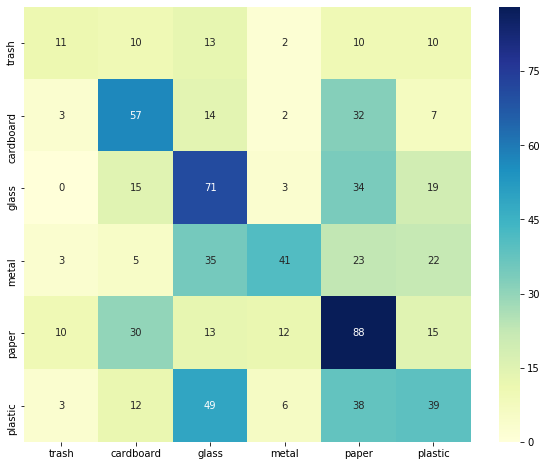

In [100]:
import seaborn as sns 
import matplotlib.pyplot as plt

#Example of undersampling

df_knn = pd.DataFrame(knn_cm, WASTE_TYPES_NAME, WASTE_TYPES_NAME)

plt.figure(figsize=(10,8))
ax = sns.heatmap(df_knn,annot=True,fmt="d",cmap="YlGnBu")
ax.set_ylim(6.0, 0.0)
plt.savefig('analysis/knn/tenpercent_1200words_imbalance_knn_5.png')
plt.show()

In [102]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(preprocessed_image, label_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [106]:
dump(knn, 'data/models/knn/tenpercent_1200words_imbalanced_knn_5.joblib')
dump(nb, 'data/models/nb/tenpercent_1200words_imbalanced_nb.joblib')

['data/models/nb/tenpercent_1200words_imbalanced_nb.joblib']

In [104]:
pred = nb.predict(processed_feature_test)
nb_cm = confusion_matrix(label_test, pred)
print("Individual scores:")
print(f1_score(label_test, pred, average = None))
print("\nAverage score: %d" %(f1_score(label_test, pred, average = 'micro')))

Individual scores:
[0.3        0.52447552 0.42666667 0.46153846 0.55555556 0.56505576]

Average score: 0


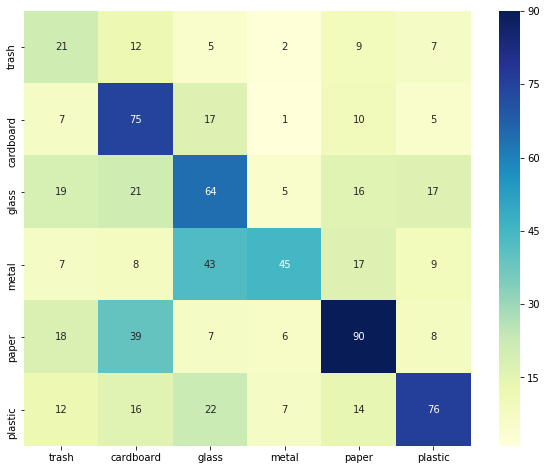

In [105]:
df_nb = pd.DataFrame(nb_cm, WASTE_TYPES_NAME, WASTE_TYPES_NAME)

plt.figure(figsize=(10,8))
ax = sns.heatmap(df_nb,annot=True,fmt="d",cmap="YlGnBu")
ax.set_ylim(6.0, 0.0)
plt.savefig('analysis/nb/tenpercent_1200words_imbalance_nb.png')
plt.show()

In [158]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(criterion='gini', class_weight='balanced')
dec_tree.fit(preprocessed_image, label_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [159]:
pred = dec_tree.predict(processed_feature_test)
dec_tree_cm = confusion_matrix(label_test, pred)
print("Individual scores:")
print(f1_score(label_test, pred, average = None))
print("\nAverage score: %d" %(f1_score(label_test, pred, average = 'micro')))

Individual scores:
[0.06451613 0.34821429 0.24605678 0.31441048 0.45348837 0.3713355 ]

Average score: 0


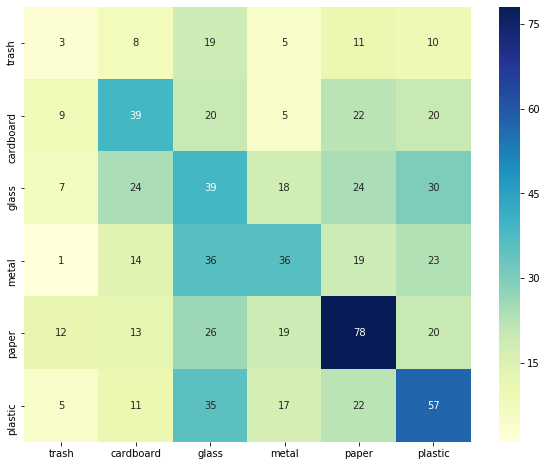

In [160]:
dec_tree_df = pd.DataFrame(dec_tree_cm, WASTE_TYPES_NAME, WASTE_TYPES_NAME)

plt.figure(figsize=(10,8))
ax = sns.heatmap(dec_tree_df,annot=True,fmt="d",cmap="YlGnBu")
ax.set_ylim(6.0, 0.0)
plt.savefig('analysis/dec_tree/gini_dec_tree.png')
plt.show()

In [171]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy')
rand_forest.fit(preprocessed_image, label_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [172]:
pred = rand_forest.predict(processed_feature_test)
rand_forest_cm = confusion_matrix(label_test, pred)
print("Individual scores:")
print(f1_score(label_test, pred, average = None))
print("\nAverage score: %d" %(f1_score(label_test, pred, average = 'micro')))

Individual scores:
[0.03508772 0.61946903 0.56213018 0.56281407 0.7382199  0.62179487]

Average score: 0


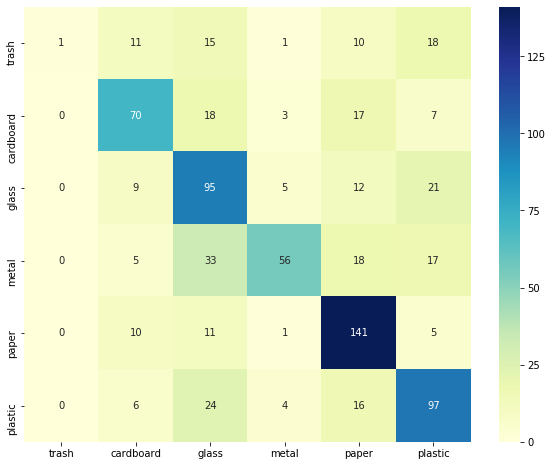

In [173]:
rand_forest_df = pd.DataFrame(rand_forest_cm, WASTE_TYPES_NAME, WASTE_TYPES_NAME)

plt.figure(figsize=(10,8))
ax = sns.heatmap(rand_forest_df,annot=True,fmt="d",cmap="YlGnBu")
ax.set_ylim(6.0, 0.0)
plt.savefig('analysis/rand_forest/entropy_1000_tree_rand_forest.png')
plt.show()

In [141]:
dump(knn, 'data/models/knn/tenpercent_1200words_imbalanced_knn_5.joblib')

['data/models/nb/10000_tree_rand_forest.joblib']

In [ ]:
dump(nb, 'data/models/nb/tenpercent_1200words_imbalanced_nb.joblib')

In [161]:
dump(dec_tree, 'data/models/dec_tree/gini_dec_tree.joblib')

['data/models/knn/gini_dec_tree.joblib']

In [174]:
dump(rand_forest, 'data/models/rand_forest/entropy_1000_tree_rand_forest.joblib')

['data/models/rand_forest/entropy_1000_tree_rand_forest.joblib']